## Business Problem 
* The aim of this project is to detect given a blood sample(cells) image whether a patient has malaria or not. This project is a implementation of the research paper Applying Faster R-CNN for Object Detection on Malaria Images https://arxiv.org/abs/1804.09548

## Business Constraints 
* Interpretability is essential we should know why a person has malaria given a these blood sample images.
* No low latency Requirement as we want to know whether a pateint has malaria or not so we can wait for the prediction little bit.
* We also need the probability of each class belonging.

## ML Problem Formulation
* It is an object detection problem which we will be solving using Faster R-CNN

## Data
* Data is in the form of json files in which given a particular image bounding boxes represents the particular cell and its category

# Loss Function

<img src="loss_fn.png">

<img src="loss_fn_cls.png">

<img src="loss_fn_ex.png">

## Files and Approach

* I have used 3 files including this one
* 1. 1_Faster_R-CNN_Malaria - In this file i have preprocessed the json file and then labelled all the cells other than rbc as non-rbc and then built a faster r-cnn model using tensorflow object detection API and i have used pre training faster R-CNN+Resnet-101-COCO and configuration file from pets data set faster_rcnn_resnet-101_pets.config
* 2. 2_Non_RBC_Cell_Processing and VGG16 Finetuned_Model - In this file i have first pre-processed,cropeed and stored all the non-rbc cell images and then trained a Fine tuned VGG16 for non-rbc cell images for further classfication of cells after object detection.
* 3. 4_Two_Stage_Classification - In this file i have implemented the two stage classification using models which i got in above files, So 1_Faster_R-CNN_Malaria will be my object detector which detects cells as rbc and non-rbc and then for non-rbc i have used both vgg_16 and alexnet fine tuned model to classifiy given non-rbc cell into 5 non-rbc classes. vgg_16 model is performing far better than alexnet model.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths 
import os
import random
import matplotlib.image as mpimg
%matplotlib inline
from matplotlib import patches
import pickle
from collections import defaultdict

In [6]:
train=pd.read_json ('training.json')

In [7]:
from tqdm import tqdm
data=[]
for i in tqdm(range(train.shape[0])):
    for j in range(len(train.iloc[i,1])):
        img_name=train.iloc[i,0]['pathname'].split('/')[2]
        label=train.iloc[i,1][j]['category']
        x_min=train.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=train.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=train.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=train.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
        

100%|█████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:05<00:00, 234.54it/s]


In [8]:
df_train=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])

In [9]:
df_train.head()

img_name           label  x_min  y_min  \
0  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png  red blood cell   1440   1057   
1  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png  red blood cell   1303    868   
2  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png  red blood cell    900    578   
3  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png  red blood cell    611    304   
4  8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png  red blood cell    881    198   

   x_max  y_max  
0   1540   1158  
1   1403    971  
2   1008    689  
3    713    408  
4   1003    312

In [10]:
df_train.label.unique()

array(['red blood cell', 'trophozoite', 'schizont', 'difficult', 'ring',
       'leukocyte', 'gametocyte'], dtype=object)

In [11]:
df_train.label.value_counts()

red blood cell    77420
trophozoite        1473
difficult           441
ring                353
schizont            179
gametocyte          144
leukocyte           103
Name: label, dtype: int64

In [12]:
non_rbc=['trophozoite', 'schizont', 'ring','gametocyte','leukocyte']

In [13]:
df_train.shape

(80113, 6)

In [14]:
# converting all cells other than rbc to non-rbc
for i in tqdm(range(80113)):
    if df_train.iloc[i,1] in non_rbc:
        df_train.iloc[i,1]='non_rbc'

100%|██████████████████████████████████████████████████████████████████████████| 80113/80113 [00:24<00:00, 3218.51it/s]


In [15]:
df_train.label.unique()

array(['red blood cell', 'non_rbc', 'difficult'], dtype=object)

In [16]:
df_train.label.value_counts()

red blood cell    77420
non_rbc            2252
difficult           441
Name: label, dtype: int64

In [17]:
df_train.img_name=df_train.img_name.apply(lambda x: "training_images/"+str(x))

In [18]:
df_train.head()

img_name           label  x_min  \
0  training_images/8d02117d-6c71-4e47-b50a-6cc8d5...  red blood cell   1440   
1  training_images/8d02117d-6c71-4e47-b50a-6cc8d5...  red blood cell   1303   
2  training_images/8d02117d-6c71-4e47-b50a-6cc8d5...  red blood cell    900   
3  training_images/8d02117d-6c71-4e47-b50a-6cc8d5...  red blood cell    611   
4  training_images/8d02117d-6c71-4e47-b50a-6cc8d5...  red blood cell    881   

   y_min  x_max  y_max  
0   1057   1540   1158  
1    868   1403    971  
2    578   1008    689  
3    304    713    408  
4    198   1003    312

In [19]:
df_train=df_train[df_train['label']!="difficult"]

In [33]:
from collections import defaultdict
ground_truth={}
for i in tqdm(df_train.iloc[:,:].values):
    if i[0] in ground_truth:
        ground_truth[i[0]].append([i[2],i[3],i[4],i[5]])
    else:
        ground_truth[i[0]]=[[i[2],i[3],i[4],i[5]]]

100%|████████████████████████████████████████████████████████████████████████| 79672/79672 [00:00<00:00, 312298.92it/s]


In [35]:
import json
with open('ground_truth_boxes.json', 'w') as fp:
    json.dump(ground_truth, fp)

In [20]:
from tqdm import tqdm
test=pd.read_json ('test.json')

In [21]:
data=[]
for i in tqdm(range(test.shape[0])):
    for j in range(len(test.iloc[i,1])):
        img_name=test.iloc[i,0]['pathname'].split('/')[2]
        label=test.iloc[i,1][j]['category']
        x_min=test.iloc[i,1][j]['bounding_box']['minimum']['c']
        x_max=test.iloc[i,1][j]['bounding_box']['maximum']['c']
        y_min=test.iloc[i,1][j]['bounding_box']['minimum']['r']
        y_max=test.iloc[i,1][j]['bounding_box']['maximum']['r']
        
        data.append([img_name,label,x_min,y_min,x_max,y_max])
        

100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 229.18it/s]


In [22]:
df_test=pd.DataFrame(data,columns=['img_name','label','x_min','y_min','x_max','y_max'])

In [23]:
df_test.head()

img_name           label  x_min  y_min  \
0  41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg  red blood cell   1744    576   
1  41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg  red blood cell   1249    863   
2  41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg  red blood cell   1573    210   
3  41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg  red blood cell   1124   1017   
4  41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg  red blood cell   1655    572   

   x_max  y_max  
0   1883    708  
1   1373    977  
2   1711    335  
3   1253   1142  
4   1763    695

In [24]:
df_test.label.unique()

array(['red blood cell', 'trophozoite', 'ring', 'schizont', 'difficult',
       'gametocyte'], dtype=object)

In [25]:
df_test.label.value_counts()

red blood cell    5614
ring               169
trophozoite        111
gametocyte          12
schizont            11
difficult            5
Name: label, dtype: int64

In [26]:
df_test.shape

(5922, 6)

In [27]:
for i in tqdm(range(5922)):
    if df_test.iloc[i,1] in non_rbc:
        df_test.iloc[i,1]='non_rbc'

100%|███████████████████████████████████████████████████████████████████████████| 5922/5922 [00:00<00:00, 16679.29it/s]


In [28]:
df_test.label.unique()

array(['red blood cell', 'non_rbc', 'difficult'], dtype=object)

In [29]:
df_test.label.value_counts()

red blood cell    5614
non_rbc            303
difficult            5
Name: label, dtype: int64

In [30]:
df_test.img_name=df_test.img_name.apply(lambda x: "testing_images/"+str(x))

In [31]:
df_test.head()

img_name           label  x_min  \
0  testing_images/41be1bd3-0d31-4881-bf1f-3ccdfa2...  red blood cell   1744   
1  testing_images/41be1bd3-0d31-4881-bf1f-3ccdfa2...  red blood cell   1249   
2  testing_images/41be1bd3-0d31-4881-bf1f-3ccdfa2...  red blood cell   1573   
3  testing_images/41be1bd3-0d31-4881-bf1f-3ccdfa2...  red blood cell   1124   
4  testing_images/41be1bd3-0d31-4881-bf1f-3ccdfa2...  red blood cell   1655   

   y_min  x_max  y_max  
0    576   1883    708  
1    863   1373    977  
2    210   1711    335  
3   1017   1253   1142  
4    572   1763    695

In [32]:
df_test=df_test[df_test['label']!="difficult"]

In [60]:
ground_truth_test_RBC_NONRBC={}
for i in tqdm(df_test.iloc[:,:].values):
    if i[0] in ground_truth_test_RBC_NONRBC:
        ground_truth_test_RBC_NONRBC[i[0]].append([i[2],i[3],i[4],i[5]])
    else:
        ground_truth_test_RBC_NONRBC[i[0]]=[[i[2],i[3],i[4],i[5]]]
        
import json
with open('ground_truth_boxes_test_RBC_NONRBC.json', 'w') as fp:
    json.dump(ground_truth_test_RBC_NONRBC, fp)


100%|███████████████████████████████████████████████████████████████████████████| 5917/5917 [00:00<00:00, 35314.26it/s]


## Plotting Image with RBC and NON-RBC Cells

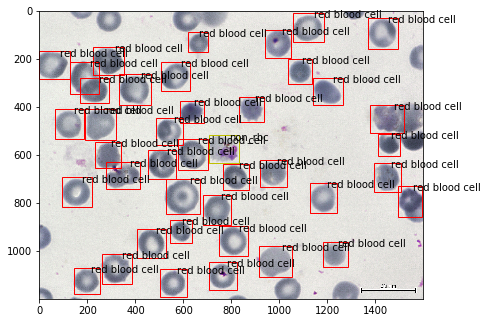

In [30]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('training_images/01b99da8-b66b-464b-a7ee-1cadab8db18b.png')
plt.imshow(image)

for _,row in df_train[df_train.img_name == "training_images/01b99da8-b66b-464b-a7ee-1cadab8db18b.png"].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        edgecolor = 'r'
        ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'non_rbc':
        edgecolor = 'y'
        ax.annotate('non_rbc', xy=(x_max-40,y_min+20))
    elif row.label == 'difficult':
        edgecolor = 'b'
        ax.annotate('difficult', xy=(x_max-40,y_min+20))

    
        
    # add bounding boxes to the image
    rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

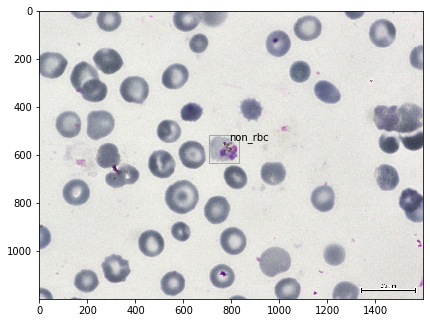

In [31]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('training_images/01b99da8-b66b-464b-a7ee-1cadab8db18b.png')
plt.imshow(image)

for _,row in df_train[df_train.img_name == "training_images/01b99da8-b66b-464b-a7ee-1cadab8db18b.png"].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    k=0
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        k=1
        #edgecolor = 'r'
        #ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'non_rbc':
        edgecolor = 'y'
        ax.annotate('non_rbc', xy=(x_max-40,y_min+20))
    elif row.label == 'difficult':
        edgecolor = 'b'
        ax.annotate('difficult', xy=(x_max-40,y_min+20))
    
    if k!=1:    
    # add bounding boxes to the image
        rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')

        ax.add_patch(rect)

## EDA Image Size

In [10]:
import os
from glob import glob
import numpy as np
import pandas as pd
from dask import bag, diagnostics 
from urllib import request
import cv2
import hvplot.pandas  # custom install
from matplotlib import pyplot as plt
%matplotlib inline
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

# parallelize

filelist = list(paths.list_images("training_images"))
print("total training images:",len(filelist))
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

total training images: 1208
[########################################] | 100% Completed | 29.3s


:Scatter   [height]   (width,count)

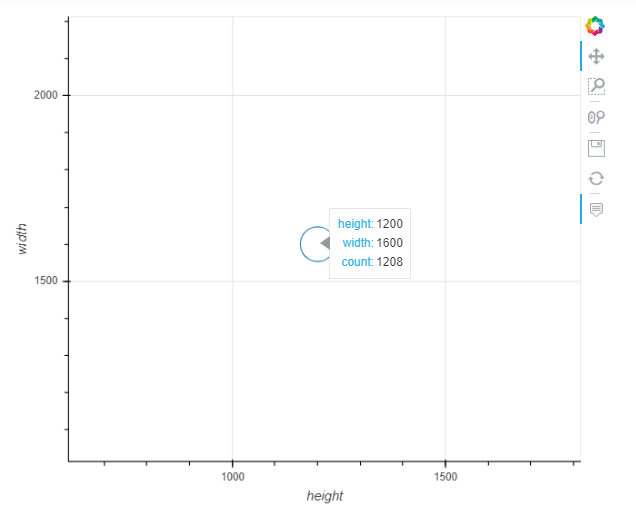

In [76]:
from IPython.display import Image
Image(filename='training_image_sizes.png')

#### All the train Images are of same size

In [11]:
filelist = list(paths.list_images("testing_images"))
print("total testing images:",len(filelist))
dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1200), ylim=(0,1200), grid=True, xticks=2, 
        yticks=2, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0)

total testing images: 120
[########################################] | 100% Completed |  4.0s


:Scatter   [height]   (width,count)

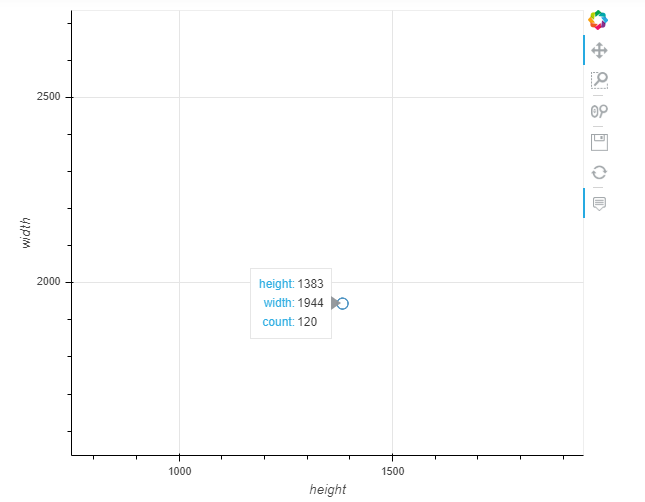

In [77]:
from IPython.display import Image
Image(filename='testing_image_size_plot.png')

#### All the test images are of same size

## Faster R-CNN Training Procedure

In [36]:
import os
from object_detection.utils.dataset_util import bytes_list_feature
from object_detection.utils.dataset_util import float_list_feature
from object_detection.utils.dataset_util import int64_list_feature
from object_detection.utils.dataset_util import int64_feature
from object_detection.utils.dataset_util import bytes_feature

In [37]:
df_train.to_csv('train_annotation.csv',index=False)
df_test.to_csv('test_annotation.csv',index=False)

NameError: name 'df_test' is not defined

In [38]:
import os
BASE_PATH="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS"
TRAIN_ANNOT_PATH=os.path.sep.join([BASE_PATH,"train_annotation.csv"])#train csv path
TEST_ANNOT_PATH=os.path.sep.join([BASE_PATH,"test_annotation.csv"])#test csv path
TRAIN_RECORD=os.path.sep.join([BASE_PATH,"records/training.record"])#record file required by Tensorflow object detection
TEST_RECORD=os.path.sep.join([BASE_PATH,"records/testing.record"])
CLASSES_FILE=os.path.sep.join([BASE_PATH,"records/classes.pbtxt"])#class file required by Tensorflow object detection
CLASSES={"red blood cell":1,"non_rbc":2}


In [39]:
#Ref- https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html
#format of data which TFOD requires
class TFAnnotation:
    def __init__(self):
        self.xMins=[]
        self.xMaxs=[]
        self.yMins=[]
        self.yMaxs=[]
        self.textLabels=[]
        self.classes=[]
        self.difficult=[]
        self.image=None
        self.width=None
        self.height=None
        self.encoding=None
        self.filename=None
        
    def build(self):
        w=int64_feature(self.width)
        h=int64_feature(self.height)
        filename=bytes_feature(self.filename.encode('utf8'))
        encoding=bytes_feature(self.filename.encode('utf8'))
        image=bytes_feature(self.image)
        xMins=float_list_feature(self.xMins)
        xMaxs=float_list_feature(self.xMaxs)
        yMins=float_list_feature(self.yMins)
        yMaxs=float_list_feature(self.yMaxs)
        textLabels=bytes_list_feature(self.textLabels)
        classes=int64_list_feature(self.classes)
        difficult=int64_list_feature(self.difficult)
        
        data={
            "image/height":h,
            "image/width":w,
            "image/filename":filename,
            "image/source_id":filename,
            "image/encoded":image,
            "image/format":encoding,
            "image/object/bbox/xmin":xMins,
            "image/object/bbox/xmax":xMaxs,
            "image/object/bbox/ymin":yMins,
            "image/object/bbox/ymax":yMaxs,
            "image/object/class/text":textLabels,
            "image/object/class/label":classes,
            "image/object/difficult":difficult,
            }
        
        return data

In [84]:
from PIL import Image
import tensorflow as tf


In [50]:
#creating class file required by TFOD
f=open(CLASSES_FILE,"w")
for (k,v) in CLASSES.items():
    item = ("item {\n"
    "\tid: " + str(v) + "\n"
    "\tname: '" + k + "'\n"
    "}\n")
    f.write(item)
f.close()

In [85]:
D={}

In [86]:
train_rows=open(TRAIN_ANNOT_PATH).read().strip().split("\n")

In [87]:
#creating the required .record file for TFOD 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
for row in tqdm(train_rows[1:]):
    row=row.split(',')
    (imagePath,label,startX,startY,endX,endY)=row
    (startX,startY)=(float(startX),float(startY))
    (endX,endY)=(float(endX),float(endY))
    if label not in CLASSES:
        continue
    p=os.path.sep.join([BASE_PATH,imagePath])
    b=D.get(p,[])
    b.append((label,(startX,startY,endX,endY)))
    D[p]=b
    
(trainKeys,testKeys)=train_test_split(list(D.keys()),test_size=.10,random_state=42)
datasets=[
    ("train",trainKeys,TRAIN_RECORD),
    ("test",testKeys,TEST_RECORD)
]
for dType,keys,outputPath in datasets:
    print("processing{}".format(dType))
    writer=tf.python_io.TFRecordWriter(outputPath)
    total=0
    for k in tqdm(keys):
        encoded=tf.gfile.GFile(k,'rb').read()
        encoded=bytes(encoded)
        pilImage=Image.open(k)
        (w,h)=pilImage.size[:2]
        filename=k.split(os.path.sep)[-1]
        encoding=filename[filename.rfind(".")+ 1:]

        tfAnnot=TFAnnotation()
        tfAnnot.image=encoded
        tfAnnot.encoding=encoding
        tfAnnot.filename=filename
        tfAnnot.width=w
        tfAnnot.height=h
        for (label,(startX,startY,endX,endY)) in D[k]:
            xMin=startX/w
            xMax=endX/w
            yMin=startY/h
            yMax=endY/h
            tfAnnot.xMins.append(xMin)
            tfAnnot.xMaxs.append(xMax)
            tfAnnot.yMins.append(yMin)
            tfAnnot.yMaxs.append(yMax)
            tfAnnot.textLabels.append(label.encode('utf8'))
            tfAnnot.classes.append(CLASSES[label])
            tfAnnot.difficult.append(0)

            total+=1
        features=tf.train.Features(feature=tfAnnot.build())
        example=tf.train.Example(features=features)

        writer.write(example.SerializeToString())
    writer.close()
    print('{} saved {}'.format(total,dType))
pickle_out = open("trainKeys.pickle","wb")
pickle.dump(trainKeys, pickle_out)
pickle_out.close()

pickle_out = open("testKeys.pickle","wb")
pickle.dump(testKeys, pickle_out)
pickle_out.close()

100%|████████████████████████████████████████████████████████████████████████| 80113/80113 [00:00<00:00, 158343.76it/s]


processingtrain


100%|██████████████████████████████████████████████████████████████████████████████| 1087/1087 [01:31<00:00, 11.92it/s]


71673 saved train
processingtest


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:09<00:00, 12.35it/s]


7999 saved test


In [113]:
pickle_in = open("trainKeys.pickle","rb")
trainKeys = pickle.load(pickle_in)
pickle_in = open("testKeys.pickle","rb")
testKeys = pickle.load(pickle_in)

## Distribution of Train Data

In [107]:
train_label_count=[]

In [108]:
for i in tqdm(trainKeys):
    for j in df_train[df_train.img_name==i.split('\\')[1]].values:
        train_label_count.append(j[1])

100%|██████████████████████████████████████████████████████████████████████████████| 1087/1087 [00:11<00:00, 98.05it/s]


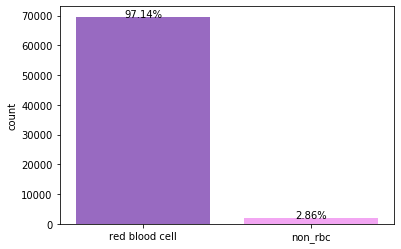

In [109]:
import seaborn as sns
ax=sns.countplot(train_label_count, palette=['#995BD0','#FF99FF'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/len(train_label_count))*100),
            ha="center") 

## Distribution of Test Data

In [110]:
test_label_count=[]

In [111]:
for i in tqdm(testKeys):
    for j in df_train[df_train.img_name==i.split('\\')[1]].values:
        test_label_count.append(j[1])

100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 112.51it/s]


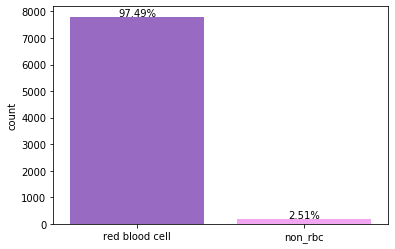

In [112]:
import seaborn as sns
ax=sns.countplot(test_label_count, palette=['#995BD0','#FF99FF'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/len(test_label_count))*100),
            ha="center") 

#### Distributions are neary same

## Configuration File for Faster RCNN

In [ ]:
"""
# Faster R-CNN with Resnet-101 (v1) configured for the Oxford-IIIT Pet Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 2
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0003
          schedule {
            step: 900000
            learning_rate: .00003
          }
          schedule {
            step: 1200000
            learning_rate: .000003
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/training/model.ckpt-13701"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 40000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/training.record"
  }
  label_map_path: "C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/classes.pbtxt"
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  num_examples: 15998 
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/testing.record"
  }
  label_map_path: "C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/classes.pbtxt"
  shuffle: false
  num_readers: 1
}
"""

# Commands for training the faster r-cnn model

## Training Faster RCNN

python object_detection/model_main.py --pipeline_config_path C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/training/faster_rcnn_malaria.config --model_dir C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/training --num_train_steps 40000 --sample_1_of_n_eval_examples 1 --alsologtostderr


## Exporting Faster RCNN Model

python .\export_inference_graph.py --input_type image_tensor --pipeline_config_path C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/training/faster_rcnn_malaria.config --trained_checkpoint_prefix C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/training/model.ckpt-13449 --output_directory C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model

tensorboard --logdir experiments --host localhost --port 8088

## MAP Scores

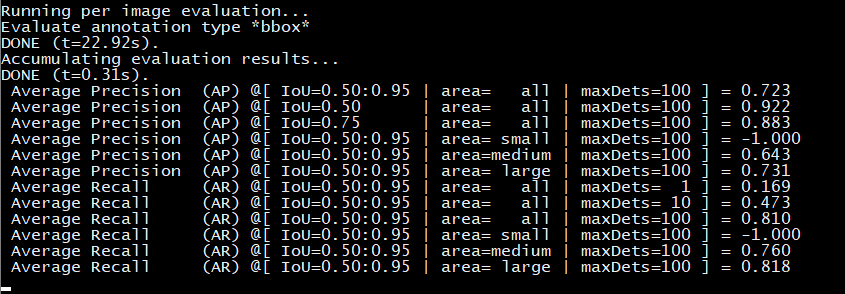

In [1]:
from IPython.display import Image
Image(filename='faster_rcnn_train.png')

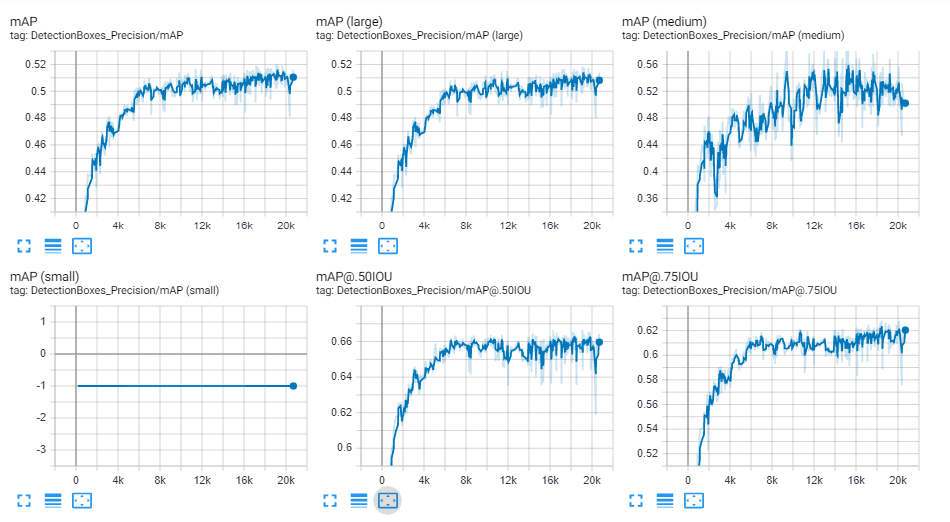

In [2]:
from IPython.display import Image
Image(filename='map_scores.png')

## LOSS

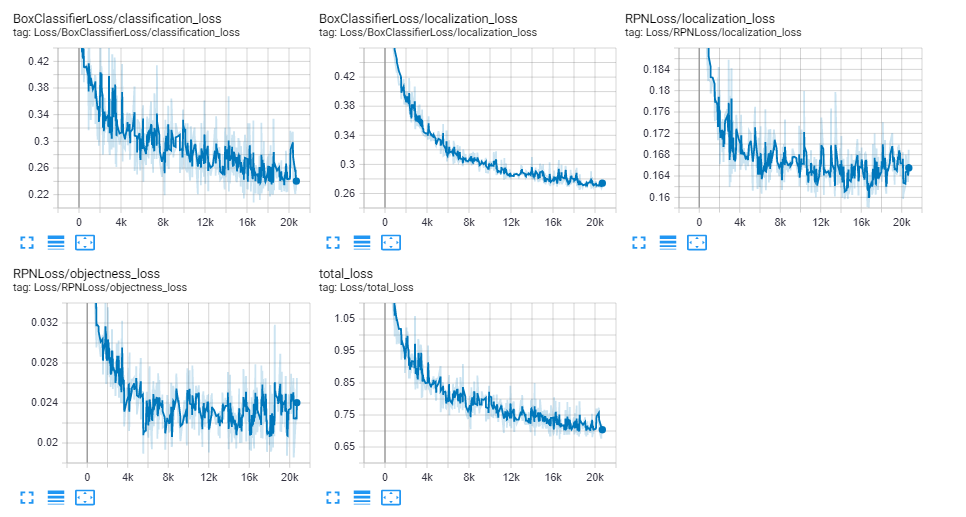

In [3]:
from IPython.display import Image
Image(filename='loss.png')

## Train_data result of Faster R-CNN

In [2]:
from object_detection.utils import label_map_util
import tensorflow as tf
import numpy as np
import imutils
import cv2

In [3]:
model="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/exported_model/frozen_inference_graph.pb"
labels_loc="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/classes.pbtxt"
image="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/testing_images/edea6ca9-3d52-4b4f-bec3-93799b1c26e3.jpg"
min_confidence=0.5
num_classes=2

In [42]:
colors=np.float64(np.array([[255,1,1],
       [86, 1,255],
       [1,231,255],
       [1,255,61],
       [214,255,1],
       [255,120,1]]))

In [43]:
training_images=np.unique(df_train.img_name.values)
print(len(training_images))

1208


In [45]:
model=tf.Graph()
with model.as_default():
    graphDef=tf.GraphDef()
    with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
        serializedGraph=f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef,name="")
        
labelMap=label_map_util.load_labelmap(labels_loc)
categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
categoryIdx=label_map_util.create_category_index(categories)

In [ ]:
predicted_boxes=defaultdict(dict)
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        train_prediction={}
        for img in tqdm(training_images):
            with open('input/detection-results/{}.txt'.format(img.split('/')[1].split('.')[0]),'a') as file:
                image=cv2.imread(img)
                (H,W)= image.shape[:2]

                if W>H and W>1000:
                    image=imutils.resize(image,width=1000)
                elif H>W and H>1000:
                    image=imutils.resize(image,height=1000)

                (H,W)=image.shape[:2]
                output=image.copy()
                image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
                image=np.expand_dims(image,axis=0)

                (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
                boxes=np.squeeze(boxes)
                scores=np.squeeze(scores)
                labels=np.squeeze(labels)
                for (box,score,label) in zip(boxes,scores,labels):
                    if score<0.4:
                        continue
                    (startY,startX,endY,endX)=box
                    startX=int(startX*W)
                    startY=int(startY*H)
                    endX=int(endX*W)
                    endY=int(endY*H)
                    if img in predicted_boxes:
                        predicted_boxes[img]['boxes'].append([startX,startY,endX,endY])
                        predicted_boxes[img]['scores'].append(score)
                    else:
                        predicted_boxes[img]['boxes']=[[startX,startY,endX,endY]]
                        predicted_boxes[img]['scores']=[score]
                    label=categoryIdx[label]
                    if label['name']=='red blood cell':
                        c='_'.join(label['name'].split(' '))
                    else:
                        c=label['name']
                    file.write('{} {} {} {} {}\n'.format(c,startX,endY,endX,startY))
                    idx=int(label["id"])-1
                    if label['name'] in train_prediction:
                        train_prediction[label['name']]+=1
                    else:
                        train_prediction[label['name']]=1      
import json
with open('predicted_boxes.json', 'w') as fp:
    json.dump(predicted_boxes, fp)
                        



  0%|                                                                                         | 0/1208 [00:00<?, ?it/s]

  0%|                                                                               | 1/1208 [00:16<5:29:40, 16.39s/it]

  0%|▏                                                                              | 2/1208 [00:18<4:02:11, 12.05s/it]

  0%|▏                                                                              | 3/1208 [00:20<3:00:54,  9.01s/it]

In [55]:
df_train.label.value_counts()[:2]

red blood cell    77420
non_rbc            2252
Name: label, dtype: int64

In [53]:
train_prediction

{'red blood cell': 71161, 'non_rbc': 2244}

In [69]:
train_prediction['red blood cell']

71161

In [71]:
accuracy_rbc=(train_prediction['red blood cell']/df_train.label.value_counts()['red blood cell'])*100
accuracy_non_rbc=(train_prediction['non_rbc']/df_train.label.value_counts()['non_rbc'])*100

In [73]:
print("Accuracy_RBC---{}%".format(accuracy_rbc))
print("Accuracy_NONRBC---{}%".format(accuracy_non_rbc))

Accuracy_RBC---91.91552570395247%
Accuracy_NONRBC---99.64476021314387%


## Test_data result of Faster R-CNN

In [33]:
testing_images=np.unique(df_test.img_name.values)
print(len(testing_images))

120


In [34]:
testing_images[0]

'testing_images/010961af-b38c-49de-aca0-e3732d73d414.jpg'

In [35]:
df_test.head(1)

img_name           label  x_min  \
0  testing_images/41be1bd3-0d31-4881-bf1f-3ccdfa2...  red blood cell   1744   

   y_min  x_max  y_max  
0    576   1883    708

In [36]:
df_test.label.unique()

array(['red blood cell', 'non_rbc'], dtype=object)

In [47]:
for img in tqdm(testing_images):
    with open('mAP/input/ground-truth/{}.txt'.format(img.split('/')[1].split('.')[0]),'a') as file:
        for i in df_test[df_test.img_name==img].values:
            if i[1]!='difficult':
                if i[1]=='red blood cell':
                    c='_'.join(i[1].split(' '))
                else:
                    c=i[1]
                file.write('{} {} {} {} {}\n'.format(c,i[2],i[5],i[4],i[3]))
            
       

100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 285.80it/s]


In [37]:
model=tf.Graph()
with model.as_default():
    graphDef=tf.GraphDef()
    with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
        serializedGraph=f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef,name="")
        
labelMap=label_map_util.load_labelmap(labels_loc)
categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
categoryIdx=label_map_util.create_category_index(categories)

In [38]:
predicted_boxes_test_RBC_NONRBC=defaultdict(dict)
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        test_prediction={}
        for img in tqdm(testing_images):
            with open('mAP/input/detection-results/{}.txt'.format(img.split('/')[1].split('.')[0]),'a') as file:
                image=cv2.imread(img)
                (H,W)= image.shape[:2]

                if W>H and W>1000:
                    image=imutils.resize(image,width=1000)
                elif H>W and H>1000:
                    image=imutils.resize(image,height=1000)

                (H,W)=image.shape[:2]
                output=image.copy()
                image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
                image=np.expand_dims(image,axis=0)

                (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
                boxes=np.squeeze(boxes)
                scores=np.squeeze(scores)
                labels=np.squeeze(labels)
                o=[]

                for (box,score,label) in zip(boxes,scores,labels):
                    if score<0.4:
                        continue
                    (startY,startX,endY,endX)=box
                    startX=int(startX*W)
                    startY=int(startY*H)
                    endX=int(endX*W)
                    endY=int(endY*H)
                    if img in predicted_boxes_test_RBC_NONRBC:
                        predicted_boxes_test_RBC_NONRBC[img]['boxes'].append([startX,startY,endX,endY])
                        predicted_boxes_test_RBC_NONRBC[img]['scores'].append(score)
                    else:
                        predicted_boxes_test_RBC_NONRBC[img]['boxes']=[[startX,startY,endX,endY]]
                        predicted_boxes_test_RBC_NONRBC[img]['scores']=[score]
                    label=categoryIdx[label]
                    if label['name']=='red blood cell':
                        c='_'.join(label['name'].split(' '))
                    else:
                        c=label['name']
                    file.write('{} {} {} {} {} {}\n'.format(c,score,startX,endY,endX,startY))
                    idx=int(label["id"])-1
                    if label['name'] in test_prediction:
                        test_prediction[label['name']]+=1
                    else:
                        test_prediction[label['name']]=1      
import json
with open('predicted_boxes_test_RBC_NONRBC.json', 'w') as fp:
    json.dump(predicted_boxes_test_RBC_NONRBC, fp)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [04:31<00:00,  2.26s/it]


TypeError: Object of type float32 is not JSON serializable

In [43]:
with open('predicted_boxes_test_RBC_NONRBC.json', 'w') as fp:
    json.dump(str(predicted_boxes_test_RBC_NONRBC), fp)

In [49]:
test_prediction

{'red blood cell': 4556, 'non_rbc': 242}

In [21]:
df_test.label.value_counts()

red blood cell    5614
non_rbc            303
Name: label, dtype: int64

In [74]:
accuracy_rbc=(test_prediction['red blood cell']/df_test.label.value_counts()['red blood cell'])*100
accuracy_non_rbc=(test_prediction['non_rbc']/df_test.label.value_counts()['non_rbc'])*100

In [75]:
print("Accuracy_RBC---{}%".format(accuracy_rbc))
print("Accuracy_NONRBC---{}%".format(accuracy_non_rbc))

Accuracy_RBC---81.15425721410759%
Accuracy_NONRBC---79.86798679867987%


## Testing Random images for bounding Boxes prediction

In [22]:
from object_detection.utils import label_map_util
import tensorflow as tf
import numpy as np
import imutils
import cv2

In [40]:
model="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/exported_model/frozen_inference_graph.pb"
labels_loc="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/records/classes.pbtxt"
image="C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/testing_images/edea6ca9-3d52-4b4f-bec3-93799b1c26e3.jpg"
min_confidence=0.5
num_classes=2

In [41]:
colors=np.float64(np.array([[255,1,1],
       [86, 1,255],
       [1,231,255],
       [1,255,61],
       [214,255,1],
       [255,120,1]]))

In [42]:
training_images=np.unique(df_train.img_name.values)
print(len(training_images))

1208


In [43]:
model=tf.Graph()
with model.as_default():
    graphDef=tf.GraphDef()
    with tf.gfile.GFile("C:/Users/SKS/Desktop/AAIC/Malaria_Detection_TS/experiments/exported_model/frozen_inference_graph.pb","rb") as f:
        serializedGraph=f.read()
        graphDef.ParseFromString(serializedGraph)
        tf.import_graph_def(graphDef,name="")
        
labelMap=label_map_util.load_labelmap(labels_loc)
categories=label_map_util.convert_label_map_to_categories(labelMap,max_num_classes=num_classes,use_display_name=True)
categoryIdx=label_map_util.create_category_index(categories)

In [44]:
image_random=random.choice(training_images)

In [46]:
import random
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        train_prediction={}
        for img in tqdm([image_random]):
            image=cv2.imread(img)
            (H,W)= image.shape[:2]

            if W>H and W>1000:
                image=imutils.resize(image,width=1000)
            elif H>W and H>1000:
                image=imutils.resize(image,height=1000)

            (H,W)=image.shape[:2]
            output=image.copy()
            image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
            image=np.expand_dims(image,axis=0)

            (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
            boxes=np.squeeze(boxes)
            scores=np.squeeze(scores)
            labels=np.squeeze(labels)
            for (box,score,label) in zip(boxes,scores,labels):
                if score<0.4:
                    continue
                (startY,startX,endY,endX)=box
                startX=int(startX*W)
                startY=int(startY*H)
                endX=int(endX*W)
                endY=int(endY*H)

                label=categoryIdx[label]
                idx=int(label["id"])-1
                #print("label is {} and score is {}".format(label,score))
                label="{}: {:.2f}".format(label["name"],score)
                cv2.rectangle(output,(startX,startY),(endX,endY),colors[idx],2)
                y=startY-10 if startY-10>10 else startY+10 
                cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,colors[idx],1)
            output = cv2.resize(output, (500, 400))  
            cv2.imshow("output",output)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:43<00:00, 43.12s/it]


# Training Data

## Orignal Training Image with Bounding Boxes and Labels

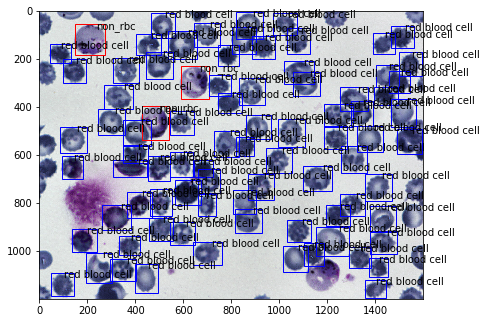

In [49]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread(image_random)
plt.imshow(image)

for _,row in df_train[df_train.img_name == image_random].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'non_rbc':
        edgecolor = 'r'
        ax.annotate('non_rbc', xy=(x_max-40,y_min+20))
    # add bounding boxes to the image
    rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

## Predicted Training Image with Bouding Boxes and Labels

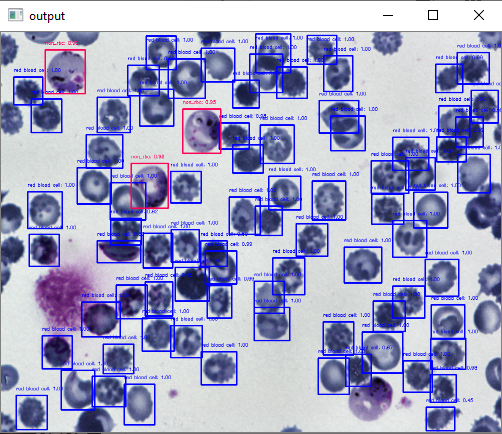

In [48]:
from IPython.display import Image
Image(filename='train_rbc_non_rbc.png')

# Testing Data

In [50]:
testing_images=np.unique(df_test.img_name.values)
print(len(testing_images))

120


In [63]:
image_random=random.choice(testing_images)

In [64]:
import random
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        train_prediction={}
        for img in tqdm([image_random]):
            image=cv2.imread(img)
            (H,W)= image.shape[:2]

            if W>H and W>1000:
                image=imutils.resize(image,width=1000)
            elif H>W and H>1000:
                image=imutils.resize(image,height=1000)

            (H,W)=image.shape[:2]
            output=image.copy()
            image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
            image=np.expand_dims(image,axis=0)

            (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
            boxes=np.squeeze(boxes)
            scores=np.squeeze(scores)
            labels=np.squeeze(labels)
            for (box,score,label) in zip(boxes,scores,labels):
                if score<0.4:
                    continue
                (startY,startX,endY,endX)=box
                startX=int(startX*W)
                startY=int(startY*H)
                endX=int(endX*W)
                endY=int(endY*H)

                label=categoryIdx[label]
                idx=int(label["id"])-1
                #print("label is {} and score is {}".format(label,score))
                label="{}: {:.2f}".format(label["name"],score)
                cv2.rectangle(output,(startX,startY),(endX,endY),colors[idx],2)
                y=startY-10 if startY-10>10 else startY+10 
                cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,colors[idx],1)
            output = cv2.resize(output, (500, 400))  
            cv2.imshow("output",output)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.55s/it]


# #1

## Orignal Testing Image with Bounding Boxes and Labels

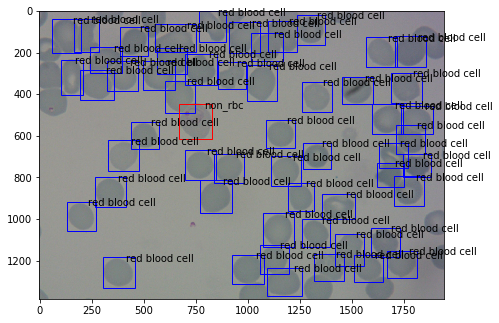

In [66]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread(image_random)
plt.imshow(image)

for _,row in df_test[df_test.img_name == image_random].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'non_rbc':
        edgecolor = 'r'
        ax.annotate('non_rbc', xy=(x_max-40,y_min+20))
    # add bounding boxes to the image
    rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

## Predicted Testing Image with Bounding Boxes and Labels

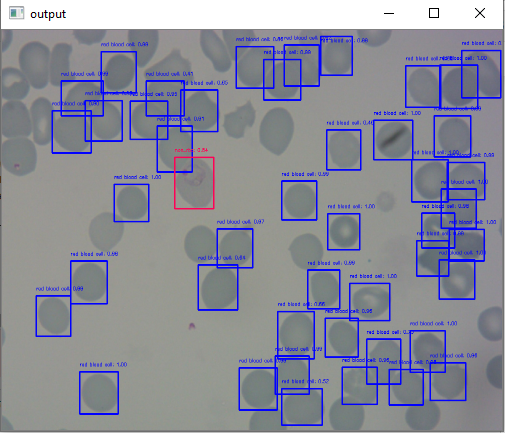

In [67]:
from IPython.display import Image
Image(filename='test_rbc_non_rbc.png')

In [68]:
image_random=random.choice(testing_images)

In [69]:
import random
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        train_prediction={}
        for img in tqdm([image_random]):
            image=cv2.imread(img)
            (H,W)= image.shape[:2]

            if W>H and W>1000:
                image=imutils.resize(image,width=1000)
            elif H>W and H>1000:
                image=imutils.resize(image,height=1000)

            (H,W)=image.shape[:2]
            output=image.copy()
            image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
            image=np.expand_dims(image,axis=0)

            (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
            boxes=np.squeeze(boxes)
            scores=np.squeeze(scores)
            labels=np.squeeze(labels)
            for (box,score,label) in zip(boxes,scores,labels):
                if score<0.4:
                    continue
                (startY,startX,endY,endX)=box
                startX=int(startX*W)
                startY=int(startY*H)
                endX=int(endX*W)
                endY=int(endY*H)

                label=categoryIdx[label]
                idx=int(label["id"])-1
                #print("label is {} and score is {}".format(label,score))
                label="{}: {:.2f}".format(label["name"],score)
                cv2.rectangle(output,(startX,startY),(endX,endY),colors[idx],2)
                y=startY-10 if startY-10>10 else startY+10 
                cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,colors[idx],1)
            output = cv2.resize(output, (500, 400))  
            cv2.imshow("output",output)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.14s/it]


# #2

## Orignal Testing Image with Bounding Boxes and Labels

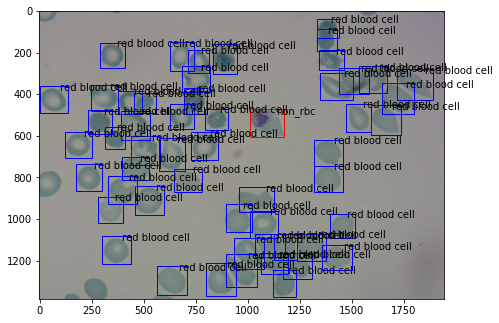

In [70]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread(image_random)
plt.imshow(image)

for _,row in df_test[df_test.img_name == image_random].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'non_rbc':
        edgecolor = 'r'
        ax.annotate('non_rbc', xy=(x_max-40,y_min+20))
    # add bounding boxes to the image
    rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

## Predicted Testing Image with Bounding Boxes and Labels

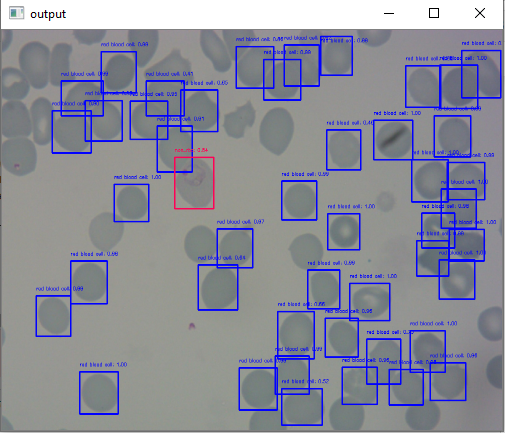

In [71]:
from IPython.display import Image
Image(filename='test_rbc_non_rbc.png')

In [72]:
image_random=random.choice(testing_images)

In [73]:
import random
with model.as_default():
    with tf.Session(graph=model) as sess:
        imageTensor=model.get_tensor_by_name("image_tensor:0")
        boxesTensor=model.get_tensor_by_name("detection_boxes:0")
        scoresTensor=model.get_tensor_by_name("detection_scores:0")
        classesTensor=model.get_tensor_by_name("detection_classes:0")
        numDetections=model.get_tensor_by_name("num_detections:0")
        train_prediction={}
        for img in tqdm([image_random]):
            image=cv2.imread(img)
            (H,W)= image.shape[:2]

            if W>H and W>1000:
                image=imutils.resize(image,width=1000)
            elif H>W and H>1000:
                image=imutils.resize(image,height=1000)

            (H,W)=image.shape[:2]
            output=image.copy()
            image=cv2.cvtColor(image.copy(),cv2.COLOR_BGR2RGB)
            image=np.expand_dims(image,axis=0)

            (boxes,scores,labels,N)= sess.run([boxesTensor,scoresTensor,classesTensor,numDetections],feed_dict={imageTensor:image})
            boxes=np.squeeze(boxes)
            scores=np.squeeze(scores)
            labels=np.squeeze(labels)
            for (box,score,label) in zip(boxes,scores,labels):
                if score<0.4:
                    continue
                (startY,startX,endY,endX)=box
                startX=int(startX*W)
                startY=int(startY*H)
                endX=int(endX*W)
                endY=int(endY*H)

                label=categoryIdx[label]
                idx=int(label["id"])-1
                #print("label is {} and score is {}".format(label,score))
                label="{}: {:.2f}".format(label["name"],score)
                cv2.rectangle(output,(startX,startY),(endX,endY),colors[idx],2)
                y=startY-10 if startY-10>10 else startY+10 
                cv2.putText(output,label,(startX,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,colors[idx],1)
            output = cv2.resize(output, (500, 400))  
            cv2.imshow("output",output)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.70s/it]


# #3

## Orignal Testing Image with Bounding Boxes and Labels

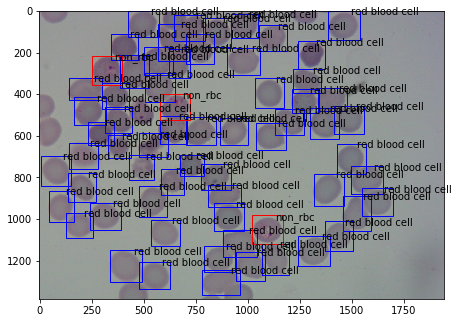

In [74]:
#Ref- https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread(image_random)
plt.imshow(image)

for _,row in df_test[df_test.img_name == image_random].iterrows():
    x_min = row.x_min
    x_max = row.x_max
    y_min = row.y_min
    y_max = row.y_max
    
    width = x_max - x_min
    height = y_max - y_min
    
    # assign different color to different classes of objects
    if row.label == 'red blood cell':
        edgecolor = 'b'
        ax.annotate('red blood cell', xy=(x_max-40,y_min+20))
    elif row.label == 'non_rbc':
        edgecolor = 'r'
        ax.annotate('non_rbc', xy=(x_max-40,y_min+20))
    # add bounding boxes to the image
    rect = patches.Rectangle((x_min,y_min), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

## Predicted Testing Image with Bounding Boxes and Labels

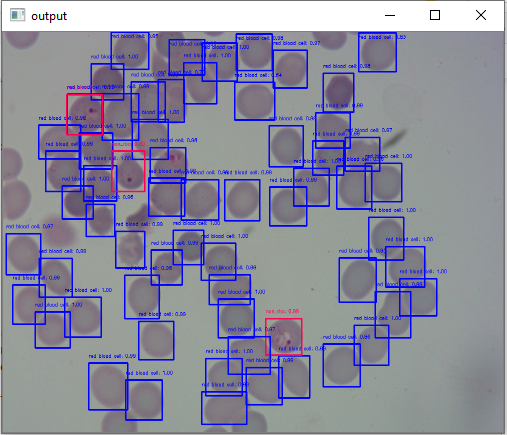

In [75]:
from IPython.display import Image
Image(filename='test_rbc_non_rbc3.png')